### Viewing the data

In [2]:
# Let's import some basic libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pathlib
from datetime import datetime

In [3]:
def read_csvs(country_list=None):
    """
    Reads all csv files in folder path given and stores them in a single dataframe df 
    Parameters: list of countries to read their csv
    ----------
    Returns
    -------
    pandas.DataFrame
        Dataframe where rows are individual data and columns for indicative
        information on the data like datetime, month, week, country etc
    """

    df = pd.DataFrame()
    dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')

    # For every csv file in folder 
    for csv in pathlib.Path('../Temp Load Data/').glob('*.csv'):
        if(country_list is None or csv.stem in country_list):            
            print("Loading dataset: "+csv.stem)
            temp_df = pd.read_csv(csv,
                                  parse_dates=['Date'],
                                  dayfirst=True,
                                  date_parser=dateparse)
            temp_df['country'] = csv.stem #set cokumn with the name of the dataset this datum came from
            df = pd.concat([df,temp_df]) 
    print('Data loading complete!')
    # sort values based on Start column (Datetime)
    df = df[df['year'] != 2022] # remove rows of year 2022 since its an incomplete year (not currently ended)
    if(country_list is None):
        df.sort_values(by=['Date'], ascending=True, inplace=True)
    df['Unnamed: 0'] = range(1, len(df) + 1)     # Reset "Unnamed: 0" based on concated df 
    return df

country_list = ['Austria']
df = read_csvs(country_list)
df_backup = df.copy()

Loading dataset: Austria
Data loading complete!


### Preparing the data in general

#### Categorical variables: one-hot encoding

A column like weekday actually contains 7 possible values, 0 through 6, each of which represents a different day of the week. Instead of representing this data as 1 feature with 7 values, it works better if we represent if as 7 binary features. This process is known as one-hot encoding and is nicely explained by Chris Albon [here](https://chrisalbon.com/machine_learning/preprocessing_structured_data/one-hot_encode_nominal_categorical_features/). 
Note that 'holiday' is effectively already one-hot encoded as it either has a value 0 for 'not a holiday' or 1 for 'is a holiday'.

#### Continuous variables: scaling
It is common practice to scale the continuous variables, i.e. to standardize them on a zero mean with a standard deviation of 1. We do this even for 'cnt' which is our target variable, and therefore we need to be able to get back again to get an actual number of bikes predicted so we'll save away the various means and standard deviations for converting back later.

#### Data we won't use

### Preparing the data for training

#### Train / test / validation split
This is a timeseries problem, so it would be typical to train on the earlier data, and test / validate on the later data.

In [25]:
def train_test_valid_split(df):
    """
    we choose to split data with validation/test data to be at the end of time series
    Since it's a time series, it is intuitive to predict future values, rather than values in between
    validation/test should hold at least an entire year, since:
        - most seasonality exists between years
        - there are fluctuation inside year (e.g heatwaves at summer)
    Parameters:
        pandas.dataframe containing dataframe to split
    Returns:
        pandas.dataframe containing train/test/valiation data
        pandas.dataframe containing valiation data
        pandas.dataframe containing test data
    """
    # train_data: data from year [2015,2019]
    # validation_data: data from year 2020
    # test_data: data from year 2021
    # drop all columns except 'Load' (use 'backup_df' to restore them)
    train_data = df[~df['year'].isin(['2020','2021'])][['Load']]
    test_data = df[df['year'] == 2021][['Load']]
    validation_data = df[df['year'] == 2020][['Load']]

    print("dataframe shape: {}".format(df.shape))
    print("train shape: {}".format(train_data.shape))
    print("test shape: {}".format(test_data.shape))
    print("validation shape: {}".format(validation_data.shape))
    
    return train_data, test_data, validation_data 

df = df_backup.copy()

# Standardize features by removing the mean (=0) and scaling to unit(=1) variance
df[['Load']] = StandardScaler().fit_transform(df[['Load']])

# split data in train/test/validation
train_data, test_data, validation_data = train_test_valid_split(df)
validation_data.head()

dataframe shape: (58993, 19)
train shape: (58993, 1)
test shape: (8760, 1)
validation shape: (8784, 1)


,Load
41449,-0.559679
41450,-0.764130
41451,-0.898733
41452,-1.009325
41453,-1.239969


In [26]:
def feauture_target_split(df, lookback_window, forecast_horizon):
    """
    This function gets a column of a dataframe and splits it to input and target
    
    **lookback_window**
    In a for-loop of 'lookback_window' max iterations, starting from 0 
    At N-th iteration (iter): 
        1. create a shifted version of 'Load' column by N rows (vertically) and 
        2. stores it in a column* (feauture_'N')

    Same pseudo-code for 'forecast_horizon' loop
    
    *At first iterations of both loops, the new columns (feauture/target) are going to be firstly created
    but for each iteration, the same columns are going to be used
    
    We store each new column created in a dictionary which, at the end, convert it to dataframe
    The reason behind this choice is that if it was initially a dataframe, for large amount of loops,
    fast insertion of new columns would cause a performance issue (slower) even though the end result
    would propably not be altered
    
    Parameters: 
        df: pandas.dataframe containing column to parse
        lookback_window: lookback_window - # feature columns - # inputs in model
        forecast_horizon: forecast_horizon - # target columns - # outputs in model
    ----------
    Returns
        'subset'_X: pandas.dataframe containing feautures of df after preprocess for model
        'subset'_Y: pandas.dataframe containing targets of df after preprocess for model
    -------
    """

    print(f"lookback_window: {lookback_window}")
    print(f"forecast_horizon: {forecast_horizon}")

    # Reset "Unnamed: 0" based on concated df 
    df['Unnamed: 0'] = range(1, len(df) + 1)

    df_copy = df.copy()    

    df_new = {}
        
    for inc in range(0,int(lookback_window)):
        df_new['feauture_' + str(inc)] = df_copy['Load'].shift(-inc)

    # shift 'load' column permanently for as many shifts happened at 'lookback_window' loops  
    df_copy['Load'] = df_copy['Load'].shift(-int(lookback_window))
                    
    for inc in range(0,int(forecast_horizon)):
        df_new['target_' + str(inc)] = df_copy['Load'].shift(-inc)    
    
    df_new = pd.DataFrame(df_new, index=df_copy.index)
    df_new = df_new.dropna().reset_index(drop=True)    
                        
    # store new dataset to csv (if needed) 
    df_new.to_csv("preprocess_for_model.csv")
    print("Done")
    
    return df_new.iloc[:,:lookback_window] , df_new.iloc[:,-forecast_horizon:]
    
    
lookback_window = 168 # 7 days (* 24 hours)
forecast_horizon = 36

# 'subset'_X: dataset containing features of subset (train/test/validation) dataframe
# 'subset'_Y: dataset containing targets of subset (train/test/validation) dataframe
train_X, train_Y = feauture_target_split(train_data, lookback_window, forecast_horizon)  
validation_X, validation_Y = feauture_target_split(validation_data, lookback_window, forecast_horizon)  
test_X, test_Y = feauture_target_split(test_data, lookback_window, forecast_horizon)  

train_X, train_Y

lookback_window: 168
forecast_horizon: 36
Done
lookback_window: 168
forecast_horizon: 36
Done
lookback_window: 168
forecast_horizon: 36
Done


(       feauture_0  feauture_1  feauture_2  feauture_3  feauture_4  feauture_5  \
 0       -0.515296   -0.825247   -1.182490   -1.257431   -1.482982   -1.333828   
 1       -0.825247   -1.182490   -1.257431   -1.482982   -1.333828   -1.003505   
 2       -1.182490   -1.257431   -1.482982   -1.333828   -1.003505   -0.192977   
 3       -1.257431   -1.482982   -1.333828   -1.003505   -0.192977    0.624827   
 4       -1.482982   -1.333828   -1.003505   -0.192977    0.624827    1.065743   
 ...           ...         ...         ...         ...         ...         ...   
 58785    1.326218    1.713292    1.777320    1.764223    1.643444    1.601245   
 58786    1.713292    1.777320    1.764223    1.643444    1.601245    1.412073   
 58787    1.777320    1.764223    1.643444    1.601245    1.412073    1.287656   
 58788    1.764223    1.643444    1.601245    1.412073    1.287656    1.219991   
 58789    1.643444    1.601245    1.412073    1.287656    1.219991    1.358232   
 
        feautu

### Defining the model and hyperparameters
Before proceeding with this section, I'd recommend taking a look at the PyTorch Lightning [INTRODUCTION GUIDE](https://pytorch-lightning.readthedocs.io/en/latest/introduction_guide.html) which describes how each section of the LightningModule template contributes and fits together. You'll recognize the same components that you're used to in PyTorch, but they are organized into functions with specific naming conventions that need to be adhered to.

In [87]:
# From here on out we start preparing the data for PyTorch - let's first get the libraries we'll need
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.profiler import Profiler, AdvancedProfiler
from pytorch_lightning.callbacks import EarlyStopping

In [102]:
class Regression(pl.LightningModule):
    """
    Regression  Techniques are used when the output is real-valued based on continuous variables. 
                For example, any time series data. This technique involves fitting a line
    Feature: Features are individual independent variables that act as the input in your system. 
             Prediction models use features to make predictions. 
             New features can also be obtained from old features using a method known as ‘feature engineering’. 
             More simply, you can consider one column of your data set to be one feature. 
             Sometimes these are also called attributes. T
             The number of features are called dimensions
    Target: The target is whatever the output of the input variables. 
            In our case, it is the output value range of load. 
            If the training set is considered then the target is the training output values that will be considered.
    Labels: Label: Labels are the final output. You can also consider the output classes to be the labels. 
            When data scientists speak of labeled data, they mean groups of samples that have been tagged to one or more labels.
    """
    
### The Model ### 
    # Initialize the layers
    # Here we have one input layer (size 'lookback_window'), 
    # and one output layer (size 1 as we are predicting a single value)
    def __init__(self, l_rate, batch_size, l_window, f_horizon):
        super(Regression, self).__init__()
        self.l_rate = l_rate
        self.batch_size = batch_size
        self.l_window = l_window
        self.f_horizon = f_horizon
        self.correct = 0
        self.loss = nn.MSELoss(reduction = 'mean')
        self.layers = nn.Sequential(
            nn.Linear(self.l_window, 32), #subtracting 'load' column used for target
            nn.ReLU(),
            nn.Linear(32, 60),            
            nn.ReLU(),
            nn.Linear(60, 60),            
            nn.ReLU(),
            nn.Linear(60, self.f_horizon)
        )

    # Perform the forward pass
    def forward(self, x):
        return self.layers(x)

### The Data Loaders ###     
    # Define functions for data loading: train / validate / test
    def train_dataloader(self):
        feature = torch.tensor(train_X.values).float() #feauture tensor train_X
        target = torch.tensor(train_Y.values).float() #target tensor train_Y
        train_dataset = TensorDataset(feature, target)  # dataset bassed on feature/target
        train_loader = DataLoader(dataset = train_dataset,
                                  batch_size = self.batch_size)
        return train_loader
            
    def test_dataloader(self):
        feature = torch.tensor(test_X.values).float()
        target = torch.tensor(test_Y.values).float()
        test_dataset = TensorDataset(feature, target)
        test_loader = DataLoader(dataset = test_dataset,
                                 batch_size = self.batch_size)
        return test_loader

    def val_dataloader(self):
        feature = torch.tensor(validation_X.values).float()
        target = torch.tensor(validation_Y.values).float()
        validation_dataset = TensorDataset(feature, target)
        validation_loader = DataLoader(dataset = validation_dataset,
                                       batch_size = self.batch_size)
        return validation_loader

### The Optimizer ### 
    # Define optimizer function: here we are using ADAM
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.l_rate)

### Training ### 
    # Define training step
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        # Add logging
        logs = {'loss': loss}
        return {'loss': loss, 'log': logs}

### Validation ###  
    # Define validation step
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        self.correct += (logits == y).sum().item() #for accuracy (recquires bound)
        self.log("val_loss", loss)
        return {'val_loss': loss}

    # Define validation epoch end
    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        tensorboard_logs = {'val_loss': avg_loss}
        print('Epoch Validation loss: '+str(avg_loss.item()))
        
        accuracy = 100 * self.correct / len(train_data)
        print("Accuracy = {} %".format(accuracy))
        return {'avg_val_loss': avg_loss, 'log': tensorboard_logs}

### Testing ###     
    # Define test step
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.loss(logits, y)
        # I want to visualize my predictions vs my actuals so here I'm going to 
        # add these lines to extract the data for plotting later on
        predictions_pred.append(logits)
        predictions_actual.append(y.data)
        return {'test_loss': loss, 'test_correct': correct, 'logits': logits}
    
    # Define test end
    def test_epoch_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        logs = {'test_loss': avg_loss}      
        return {'avg_test_loss': avg_loss, 'log': logs, 'progress_bar': logs }

In [ ]:
import warnings

warnings.filterwarnings("ignore", ".*Consider increasing the value of the `num_workers` argument*")

""" To ignore all warnings that could be false positives """
# from pytorch_lightning.utilities.warnings import PossibleUserWarning
# warnings.filterwarnings("ignore", category=PossibleUserWarning)

"""
To ensure full reproducibility from run to run you need to:
    - set seeds for pseudo-random generators, and 
    - set deterministic flag in Trainer
By setting workers=True in seed_everything(): 
    - Lightning derives unique seeds across all dataloader workers and processes for
      torch, numpy and stdlib random number generators.
    - When turned on, it ensures that e.g. data augmentations are not repeated across workers.

Instead of 'choosing' a number of epochs you instead save the network weights from the 'best' epoch. 
This optimal epoch is determined by the optimal (less possible) validation loss.
Therefore, we apply early stopping of our training at minimum value of validation loss
"""
pl.seed_everything(42, workers=True)
l_rate = 0.001 # learning rate of model
batch_size = 32 # batch_size
# lookback_window = 15
# forecast_horizon = 36
model = Regression(l_rate, batch_size, lookback_window, forecast_horizon)

# fast_dev_run: Option to check if it's working at all 
# auto_lr_find: Option to automatically find best l_rate
# auto_scale_batch_size: automatically select batch size (power/bin_search)
# deterministic: model creates reproducable results
# benchmark: flag to speedup training (cannot be used with deterministic)
# earlyStopping: callback used to stop training when 'val_loss' has stopped decreasing ('min')
trainer = Trainer(max_epochs=20, auto_scale_batch_size=None, 
                  callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                  auto_lr_find=True,
                  deterministic=True)               

# Dynamically find best learning rate
# lr_finder = trainer.tuner.lr_find(model) # Run learning rate finder
# fig = lr_finder.plot(suggest=True) # Plot
# fig.show()
# model.hparams.lr = str(lr_finder.suggestion())

trainer.fit(model) # Fit model

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name   | Type       | Params
--------------------------------------
0 | loss   | MSELoss    | 0     
1 | layers | Sequential | 13.2 K
--------------------------------------
13.2 K    Trainable params
0         Non-trainable params
13.2 K    Total params
0.053     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Epoch Validation loss: 1.5528191328048706
Accuracy = 0.0 %


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.4131711721420288
Accuracy = 0.0 %


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.32437074184417725
Accuracy = 0.0 %


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.2973669469356537
Accuracy = 0.0 %


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.27005016803741455
Accuracy = 0.0 %


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.24718648195266724
Accuracy = 0.0 %


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.23461578786373138
Accuracy = 0.0 %


Validation: 0it [00:00, ?it/s]

Epoch Validation loss: 0.23394446074962616
Accuracy = 0.0 %


In [30]:
# Here I'm creating 2 empty lists into which I'll be appending my predictions and actuals as I go
# - you don't have to do this, but if you want to examine them in detail or plot them, then it's convenient
predictions_pred = []
predictions_actual = []

# Either best or path to the checkpoint you wish to test. 
# If None and the model instance was passed, use the current weights. 
# Otherwise, the best model from the previous trainer.fit call will be loaded.
trainer.test(ckpt_path='best')

Restoring states from the checkpoint path at D:\University\10o εξάμηνο\Διπλωματική\code\model\lightning_logs\version_45\checkpoints\epoch=14-step=27570.ckpt
Loaded model weights from checkpoint at D:\University\10o εξάμηνο\Διπλωματική\code\model\lightning_logs\version_45\checkpoints\epoch=14-step=27570.ckpt


Testing: 0it [00:00, ?it/s]

[{}]

In [12]:
df_backup

,Date,Load,datetime,year,month,yearweek,day,hour,minute,second,weekday,monthday,weekend,yearday,timestamp,holiday,WN,country
0,2015-04-09 23:00:00,6401.0,2015-04-09 23:00:00,2015,4,14,9,23,0,0,3,8,False,98,1428620400,False,3.958333,Austria
1,2015-04-10 00:00:00,5975.0,2015-04-10 00:00:00,2015,4,14,10,0,0,0,4,9,False,99,1428624000,False,4.000000,Austria
2,2015-04-10 01:00:00,5484.0,2015-04-10 01:00:00,2015,4,14,10,1,0,0,4,9,False,99,1428627600,False,4.041667,Austria
3,2015-04-10 02:00:00,5381.0,2015-04-10 02:00:00,2015,4,14,10,2,0,0,4,9,False,99,1428631200,False,4.083333,Austria
4,2015-04-10 03:00:00,5071.0,2015-04-10 03:00:00,2015,4,14,10,3,0,0,4,9,False,99,1428634800,False,4.125000,Austria
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61150,2022-03-31 21:00:00,7516.0,2022-03-31 21:00:00,2022,3,12,31,21,0,0,3,30,False,89,1648760400,False,3.875000,Austria
61151,2022-03-31 22:00:00,7249.0,2022-03-31 22:00:00,2022,3,12,31,22,0,0,3,30,False,89,1648764000,False,3.916667,Austria
61152,2022-03-31 23:00:00,6834.0,2022-03-31 23:00:00,2022,3,12,31,23,0,0,3,30,False,89,1648767600,False,3.958333,Austria
61153,2022-04-01 00:00:00,6454.0,2022-04-01 00:00:00,2022,4,12,1,0,0,0,4,0,False,90,1648771200,False,4.000000,Austria


In [13]:
test_data

,Load,year,month,yearweek,day,hour,weekday,monthday,weekend,yearday,holiday,country
36693,6045.0,2019,6,23,16,20,6,15,1,166,0,0
36694,5990.0,2019,6,23,16,21,6,15,1,166,0,0
36695,6145.0,2019,6,23,16,22,6,15,1,166,0,0
36696,5785.0,2019,6,23,16,23,6,15,1,166,0,0
36697,5519.0,2019,6,24,17,0,0,16,1,167,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48919,5724.0,2020,11,44,7,6,5,6,0,311,0,0
48920,6084.0,2020,11,44,7,7,5,6,0,311,0,0
48921,6555.0,2020,11,44,7,8,5,6,0,311,0,0
48922,6896.0,2020,11,44,7,9,5,6,0,311,0,0


In [14]:
# Get dates for plotting
datesx = list(df_backup[-test_rows:]['datetime'])

# T.numpy(): transformation from tensors to floats

# Get predicted points (scaled back to their original size)
plot_pred = []
for i in range(len(predictions_pred)):
    plot_pred.extend(predictions_pred[i].T.numpy())

# Get actual points (scaled back to their original size) 
plot_actual = []
for i in range(len(predictions_actual)):
    plot_actual.extend(predictions_actual[i].T.numpy())  

In [15]:
plot_actual

[array([6045., 5990., 6145., 5785., 5519., 5281., 5113., 4978., 5052.,
        5372., 6393., 7516., 8030., 8040., 8162., 8320., 8252., 8300.,
        8225., 8198., 8101., 8129., 8014., 7720., 7473., 7156., 7014.,
        6391., 6020., 5605., 5502., 5310.], dtype=float32),
 array([5287., 5540., 6530., 7661., 8032., 8116., 8182., 8349., 8210.,
        8213., 8131., 8142., 8056., 7992., 8176., 7898., 7575., 7358.,
        7158., 6597., 6198., 5766., 5639., 5469., 5457., 5749., 6654.,
        7803., 8198., 8186., 8360., 8515.], dtype=float32),
 array([8489., 8470., 8426., 8309., 8242., 8201., 8124., 7853., 7436.,
        7076., 6794., 6322., 5989., 5475., 5351., 5138., 5000., 4936.,
        5006., 5472., 5814., 6003., 6237., 6337., 6346., 6140., 6036.,
        6086., 6144., 6240., 6442., 6296.], dtype=float32),
 array([6228., 6130., 6171., 5806., 5415., 5084., 4935., 4801., 4790.,
        5067., 5797., 6764., 7254., 7469., 7573., 7681., 7662., 7500.,
        7373., 7262., 7349., 7337., 736

In [16]:
plot_pred

[array([6981.791 , 6985.32  , 6988.8467, 6992.373 , 6921.7354, 6925.2627,
        6928.79  , 6932.317 , 6935.844 , 6939.3716, 6942.8994, 6946.426 ,
        6949.9526, 6953.481 , 6957.008 , 6960.5356, 6964.062 , 6967.5913,
        6971.1177, 6974.644 , 6978.172 , 6981.699 , 6985.227 , 6988.7534,
        6992.2812, 6995.8086, 6999.336 , 7002.8633, 6924.641 , 6928.1685,
        6931.6963, 6935.224 ], dtype=float32),
 array([6979.512 , 6983.0347, 6986.556 , 6990.0776, 6919.5703, 6923.0923,
        6926.6133, 6930.1343, 6933.656 , 6937.177 , 6940.698 , 6944.219 ,
        6947.7407, 6951.2627, 6954.7837, 6958.306 , 6961.8267, 6965.347 ,
        6968.8687, 6972.3906, 6975.911 , 6979.434 , 6982.9536, 6986.4756,
        6989.9976, 6993.518 , 6997.0396, 7000.5605, 6922.4995, 6926.021 ,
        6929.542 , 6933.063 ], dtype=float32),
 array([6971.415 , 6974.9424, 6978.4663, 6981.9907, 6911.3457, 6914.871 ,
        6918.3955, 6921.921 , 6925.446 , 6928.971 , 6932.496 , 6936.021 ,
        6939.547 ,

c:\users\tzort\appdata\local\programs\python\python38\lib\site-packages\numpy\core\shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


ValueError: setting an array element with a sequence.

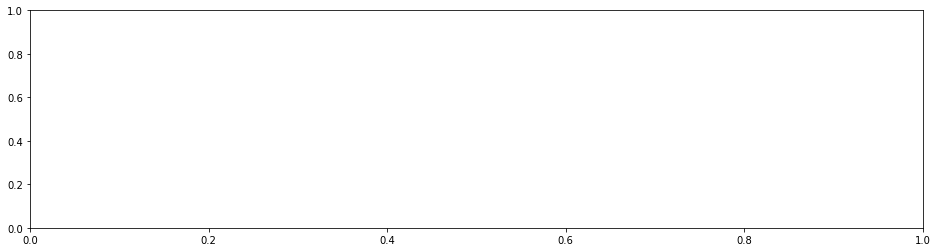

In [17]:
# And finally we can see that our network has done a decent job of estimating!
fig, ax = plt.subplots(figsize=(16,4))
ax.plot(plot_pred, label='Prediction')
ax.plot(plot_actual, label='Data')
ax.set_xticks(np.arange(len(datesx))[12::24])
ax.set_xticklabels(datesx[12::24], rotation=45)
ax.legend()

In [ ]:
# The tensorboard logger is pretty nifty too!
%load_ext tensorboard
%tensorboard --logdir lightning_logs

In [ ]:
# replace countries with a unique integer based on country_dict
country_dict = {}
for idx,country in enumerate(df['country'].unique()): country_dict[country] = idx
df.replace({"country": country_dict}, inplace=True)

# drop columns that do not contain numbers
# (since dataframe is editted to have a freq of 1hour, minute/second column is useless)
fields_to_drop = ['datetime', 'Date', 'timestamp', 'WN','minute','second']
df.drop(fields_to_drop, axis=1, inplace = True, errors='ignore')

#replace boolean true/false with 1/0
df[['weekend','holiday']] = df[['weekend','holiday']].replace({True: 1, False: 0})

In [ ]:
class MyTimeSeriesDataset(Dataset):
    def __init__(self, df, lookback_window, forecast_horizon):
        self.l_window = lookback_window
        self.f_horizon = forecast_horizon
        
        # Reset "Unnamed: 0" based on shape of df it is in 
        df['Unnamed: 0'] = range(1, len(df) + 1)
        df_new = df.copy()    
        self.dataset = df_new

        for inc in range(0,int(lookback_window)):
            df_new['feauture_' + str(inc)] = df_new['Load'].shift(-inc)
        
        # shift 'load' column permanently for as many shifts happened at 'lookback_window' loops  
        df_new['Load'] = df_new['Load'].shift(-int(lookback_window))
        
        for inc in range(0,int(forecast_horizon)):
            df_new['target_' + str(inc)] = df_new['Load'].shift(-inc)
        
        # drop lines that have NaN and reset indexing of csv file
        df_new = df_new.dropna().reset_index(drop=True)    
        
        # drop first two columns ('Unnamed: 0','Load') of dataframe
        df_new = df_new.iloc[: , 2:]        
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        input = self.dataset.iloc[:,:self.l_window] 
        output = self.dataset.iloc[:,-self.f_horizon:]
        return input,output


lookback_window = 5
forecast_horizon = 3    
trainLoader = DataLoader(MyTimeSeriesDataset(train_data,lookback_window,forecast_horizon))
valLoader = DataLoader(MyTimeSeriesDataset(validation_data,lookback_window,forecast_horizon))
testLoader = DataLoader(MyTimeSeriesDataset(test_data,lookback_window,forecast_horizon))